# Libraries

In [1]:
import torch
import matplotlib.pyplot as plt
import datasets

from sklearn.model_selection import train_test_split, GridSearchCV
from transformers import GPT2Config, GPT2Tokenizer, GPT2ForSequenceClassification, BertTokenizer, BertForSequenceClassification, XLNetTokenizer, XLNetForSequenceClassification
from torch.utils.data import TensorDataset
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix
from ml_things import plot_dict, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from joblib import dump, load

# Custom functions
import preprocessing
import models_handler


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fdavi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fdavi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\fdavi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
<frozen importlib._bootstrap>:488: DeprecationWarning: Type google._upb._message.MessageMapContainer uses PyType_Spec with a metaclass that has custom tp_new. This is deprecated and will no longer be allowed in Python 3.14.
<frozen importlib._bootstrap>:488: DeprecationWarning: Type google._upb._message.ScalarMapContainer uses PyType_Spec with a metaclass that has custom tp_new. This is deprecated and will no longer be allowed in Python 3.14.


# Constants

In [2]:
DEVICE = torch.DEVICE("cuda" if torch.cuda.is_available() else "cpu")
MAX_LENGTH = 32

# Preprocessing

- <strong>count</strong>: number of CrowdFlower users who coded each tweet
- <strong>hate_speech</strong>: number of CF users who judged the tweet to be hate speech
- <strong>offensive_language</strong>: number of CF users who judged the tweet to be offensive
- <strong>neither</strong>: number of CF users who judged the tweet to be neither offensive nor non-offensive
- <strong>class</strong>: class label for majority of CF users. 0 - hate speech 1 - offensive language 2 - neither
- <strong>tweet</strong>: text tweet

In [3]:
# Load the dataset 
data = datasets.load_dataset('ucberkeley-dlab/measuring-hate-speech')['train'].to_pandas()

# Parse text and transforming from real number to classes
data['text'] = preprocessing.parse_tweets_until_colon(data)
data['hate_speech_score'] = [2 if c < -1 else (1 if c > -1 and c < 0.5 else 0) for c in data['hate_speech_score']]

# Dropping all the other columns
data = data[['hate_speech_score', 'text']]

data.head()

,hate_speech_score,text
0,2,Yes indeed. She sort of reminds me of the elde...
1,2,The trans women reading this tweet right now i...
2,1,"These 4 broads who criticize America, what co..."
3,1,It is about time for all illegals to go back t...
4,0,For starters bend over the one in pink and kic...


# Text cleaning

- <strong>Lowercasing</strong>: Convert all text to lowercase to ensure uniformity.
- <strong>Removing Punctuation</strong>: Eliminate punctuation marks as they often don't carry much meaning in NLP tasks.
- <strong>Removing Special Characters</strong>: Remove special characters, emojis, URLs, etc., which may not contribute to the task at hand.
- <strong>Removing Stopwords</strong>: Stopwords are common words (e.g., "the", "is", "and") that occur frequently but often carry little information. Removing them can reduce noise in the data.

In [4]:
# Performing text cleaning
data["text"] = preprocessing.clean_text(data["text"])
data["text"] = preprocessing.remove_stopwords(data["text"])
data["text"] = preprocessing.apply_stemming(data["text"])
data["text"] = preprocessing.apply_lemmatization(data["text"])

data.head()

,hate_speech_score,text
0,2,ye inde sort remind elder ladi play part movi ...
1,2,tran woman read tweet right beauti
2,1,broad critic america countri flee get want mak...
3,1,time illeg go back countri origin keep freeway...
4,0,starter bend one pink kick as pussi get tast s...


## Split training/test set

- 80% → training set
- 20% → test set

In [30]:
# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(data["text"], data["hate_speech_score"], test_size=0.2, random_state=37)

# Getting the labels as tensors
labels_train = torch.tensor(list(y_train)).to(DEVICE)
labels_test = torch.tensor(list(y_test)).to(DEVICE)

# Model initialization


In [31]:

# GPT-2
tokenizer_gpt2 = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer_gpt2.pad_token = tokenizer_gpt2.eos_token  # Set padding token to eos_token

model_config_gpt2 = GPT2Config.from_pretrained('gpt2', num_labels=3, pad_token_id=tokenizer_gpt2.pad_token_id)
model_gpt2 = GPT2ForSequenceClassification(model_config_gpt2).to(DEVICE)

#BERT
tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased')
model_bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3).to(DEVICE)

# XLNET
tokenizer_xlnet = XLNetTokenizer.from_pretrained("xlnet-base-cased")
model_xlnet = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=3).to(DEVICE)


#LOGISTIC REGRESSION
vectorizer = CountVectorizer()

# Fit and transform the data
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# ML: Logistic Regression

In [6]:
logreg = LogisticRegression(n_jobs=1, C=1e5)

# Define the parameter grid
param_grid = {
    'C': [1000, 100, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'newton-cg', 'sag', 'saga'],
    'max_iter': [1000, 100, 10]
}


# Perform GridSearchCV
grid_search = GridSearchCV(logreg, param_grid, cv=5, n_jobs=-1)

# Fit the grid search on the scaled training data
grid_search.fit(X_train_vect, y_train)

# Get the best model
best_logreg = grid_search.best_estimator_

# Evaluate the best model on the test set
logreg_pred = best_logreg.predict(X_test_vect)

# Print the best parameters and accuracy
print(f"Best params: {grid_search.best_params_}")
print(f"Accuracy: {accuracy_score(logreg_pred, y_test):.3f}")

# Save the best Logistic Regression model
dump(best_logreg, 'LogisticRegression_model.joblib')

# Analysis
precision = precision_score(y_test, logreg_pred, average='weighted')
recall = recall_score(y_test, logreg_pred, average='weighted')
f1 = f1_score(y_test, logreg_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, logreg_pred)

classes = sorted(set(y_test))

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")
print("Confusion Matrix:\n", conf_matrix)

# Plot confusion matrix
print("Classification Report:")
print(classification_report(y_test, logreg_pred, target_names=['class 0', 'class 1', 'class 2']))
plot_confusion_matrix(y_true = y_test, y_pred = logreg_pred, classes=[0, 1, 2], normalize=True, magnify=0.1, use_title="Confusion Matrix - Logistic Regression")

C:\Users\fdavi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
C:\Users\fdavi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
C:\Users\fdavi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
C:\Users\fdavi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5

KeyboardInterrupt: 

# GPT-2

The OpenAI GPT-2 (Generative Pre-Trained Transformer 2) is a transfomer-based language model. It's a standard model for NLP tasks.

In [21]:

tokenized_texts_train = tokenizer_gpt2(X_train, padding=True, truncation=True, max_length=MAX_LENGTH, return_tensors='pt')
tokenized_texts_test = tokenizer_gpt2(X_test, padding=True, truncation=True, max_length=MAX_LENGTH, return_tensors='pt')

train_dataset_gpt2 = TensorDataset(tokenized_texts_train.input_ids, tokenized_texts_train.attention_mask, labels_train)
test_dataset_gpt2 = TensorDataset(tokenized_texts_test.input_ids, tokenized_texts_test.attention_mask, labels_test)

model_config_gpt2 = GPT2Config.from_pretrained('gpt2', num_labels=3, pad_token_id=tokenizer_gpt2.pad_token_id)

param_grid = {
    'batch_size': [32],
    'epochs': [3, 4],
    'lr': [1e-5, 2e-5]
}
best_params = None
best_accuracy = 0.0
best_model_gpt2 = None

for batch_size in param_grid['batch_size']:
    for epochs in param_grid['epochs']:
        for lr in param_grid['lr']:
            model_gpt2 = GPT2ForSequenceClassification(model_config_gpt2).to(DEVICE)
            model_gpt2.resize_token_embeddings(len(tokenizer_gpt2))

            model_gpt2, all_loss_gpt2, all_acc_gpt2 = models_handler.train(model_gpt2, epochs, lr, batch_size, train_dataset_gpt2, test_dataset_gpt2, "GPT-2")
            
            for val_accuracy in all_acc_gpt2['val_acc']:
                if val_accuracy > best_accuracy:
                    best_accuracy = val_accuracy
                    best_params = {'batch_size': batch_size, 'epochs': epochs, 'lr': lr}
                    best_model_gpt2 = model_gpt2

best_batch_size = best_params['batch_size']
best_epochs = best_params['epochs']
best_learning_rate = best_params['lr']

torch.save(best_model_gpt2.state_dict(), 'gpt2_model.pth') # saving gpt-2 model

print(f"Parameter tuning phase ended. Best parameters: epochs - {best_epochs}, batch size - {best_batch_size}, lr - {best_learning_rate}")

true_labels_gpt2, predicted_labels_gpt2 = models_handler.test(best_model_gpt2, best_batch_size, test_dataset_gpt2)

accuracy_gpt2 = accuracy_score(true_labels_gpt2, predicted_labels_gpt2)
print(f'GPT-2 Accuracy: {accuracy_gpt2:.4f}')

plot_dict(all_loss_gpt2, use_xlabel='Epochs', use_ylabel='Loss', use_linestyles=['-', '--'])
plot_dict(all_acc_gpt2, use_xlabel='Epochs', use_ylabel='Accuracy', use_linestyles=['-', '--'])

print("Classification Report:")
print(classification_report(true_labels_gpt2, predicted_labels_gpt2, target_names=['class 0', 'class 1', 'class 2']))

plot_confusion_matrix(y_true=true_labels_gpt2, y_pred=predicted_labels_gpt2, classes=[0, 1, 2], normalize=True, magnify=0.1, use_title="Confusion Matrix - GPT-2")

Starting training: epochs - 3, lr - 1e-05, batch size - 32


  0%|          | 0/3 [00:03<?, ?it/s]


KeyboardInterrupt: 

# BERT

BERT (Bidirectional Encoder Representations from Transformers) was developed by Google researchers.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training: epochs - 3, lr - 1e-05, batch size - 32


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1: Average Loss: 0.5481994335244771
Epoch 2: Average Loss: 0.2944554743772237
Epoch 3: Average Loss: 0.07621859522641099
Training complete: epochs - 3, lr - 1e-05, batch size - 32


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training: epochs - 3, lr - 2e-05, batch size - 32


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1: Average Loss: 0.5202785876845322
Epoch 2: Average Loss: 0.2516098818965707
Epoch 3: Average Loss: 0.07464909994356828
Training complete: epochs - 3, lr - 2e-05, batch size - 32


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training: epochs - 4, lr - 1e-05, batch size - 32


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1: Average Loss: 0.5443306550335202
Epoch 2: Average Loss: 0.2961413876259879
Epoch 3: Average Loss: 0.08191456295653335
Epoch 4: Average Loss: 0.03465378769281738
Training complete: epochs - 4, lr - 1e-05, batch size - 32


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training: epochs - 4, lr - 2e-05, batch size - 32


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1: Average Loss: 0.5176957395992894
Epoch 2: Average Loss: 0.250395518742715
Epoch 3: Average Loss: 0.0701232722952134
Epoch 4: Average Loss: 0.03954009522446416
Training complete: epochs - 4, lr - 2e-05, batch size - 32
Parameter tuning phase ended. Best parameters: epochs - 4, batch size - 32, lr - 2e-05

--- TRAINING WITH BEST PARAMETERS ---
BERT Accuracy: 0.9408380053113012


C:\Users\Eddy\AppData\Roaming\Python\Python312\site-packages\ml_things\plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


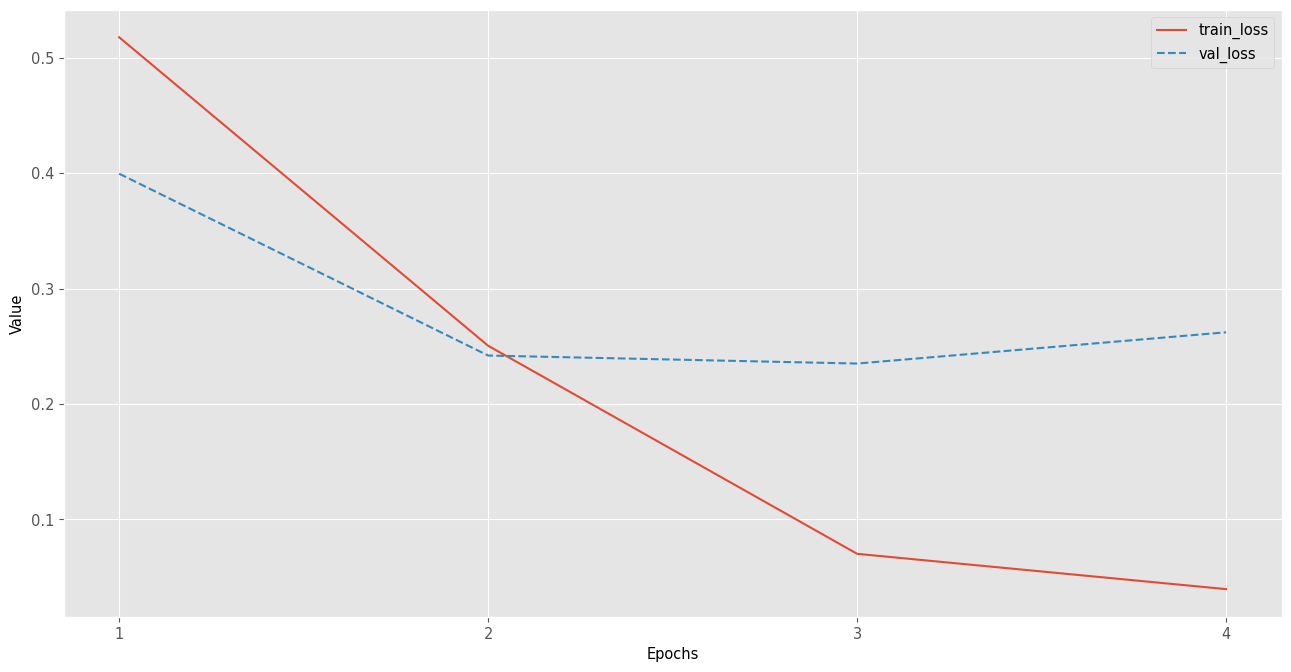

C:\Users\Eddy\AppData\Roaming\Python\Python312\site-packages\ml_things\plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


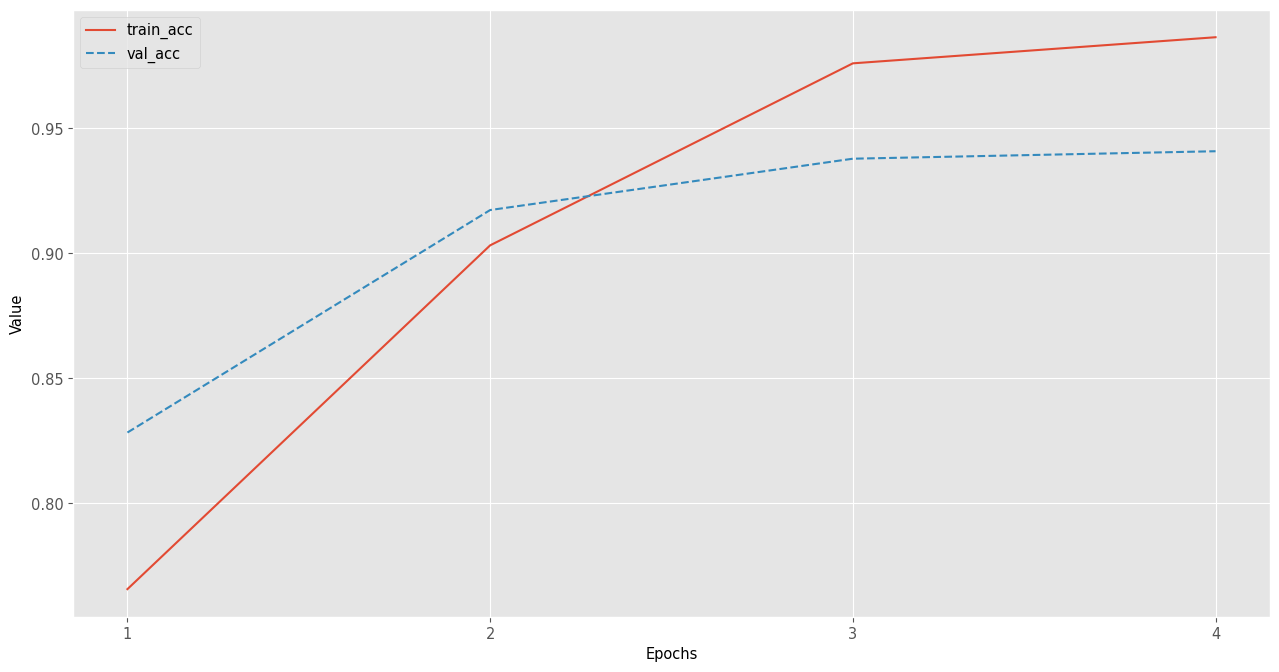

Classification Report:
              precision    recall  f1-score   support

     class 0       0.95      0.96      0.96      9913
     class 1       0.89      0.90      0.90      6546
     class 2       0.96      0.95      0.95     10653

    accuracy                           0.94     27112
   macro avg       0.93      0.94      0.94     27112
weighted avg       0.94      0.94      0.94     27112

Normalized confusion matrix


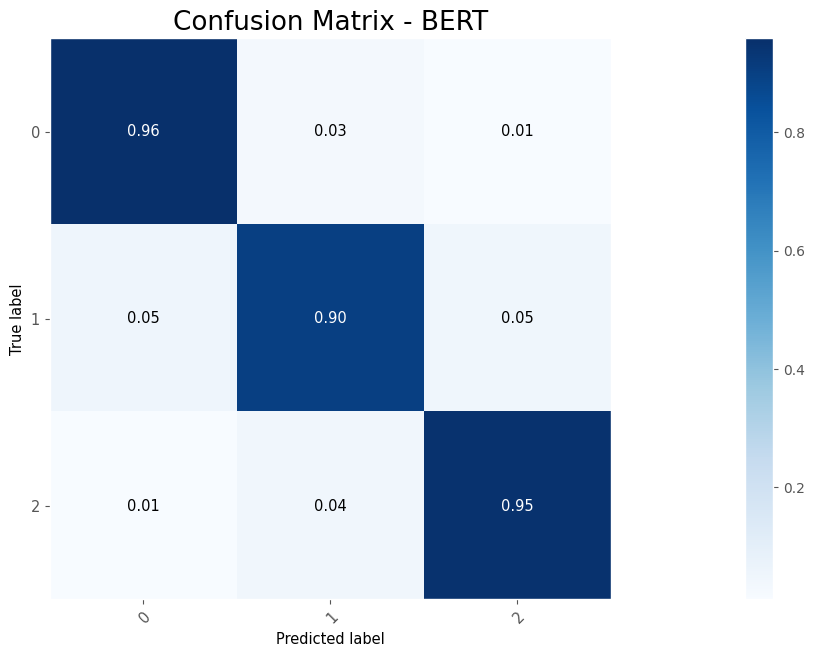

array([[0.9589428 , 0.03036417, 0.01069303],
       [0.05178735, 0.90192484, 0.04628781],
       [0.01088895, 0.04120905, 0.947902  ]])

In [34]:

tokenized_texts_train_bert = tokenizer_bert(X_train, padding=True, truncation=True, max_length=MAX_LENGTH, return_tensors='pt')
tokenized_texts_test_bert = tokenizer_bert(X_test, padding=True, truncation=True, max_length=MAX_LENGTH, return_tensors='pt')

train_dataset_bert = TensorDataset(tokenized_texts_train_bert.input_ids, tokenized_texts_train_bert.attention_mask, labels_train)
test_dataset_bert = TensorDataset(tokenized_texts_test_bert.input_ids, tokenized_texts_test_bert.attention_mask, labels_test)

param_grid = {
    'batch_size': [32],
    'epochs': [3, 4],
    'lr': [1e-5, 2e-5]
}
best_params = None
best_accuracy = 0.0
best_model_bert = None

for batch_size in param_grid['batch_size']:
    for epochs in param_grid['epochs']:
        for lr in param_grid['lr']:
            model_bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3).to(DEVICE)
            model_bert.resize_token_embeddings(len(tokenizer_bert))

            model_bert, all_loss_bert, all_acc_bert = models_handler.train(model_bert, epochs, lr, batch_size, train_dataset_bert, test_dataset_bert, "BERT")

            for val_accuracy in all_acc_gpt2['val_acc']:
                if val_accuracy > best_accuracy:
                    best_accuracy = val_accuracy
                    best_params = {'batch_size': batch_size, 'epochs': epochs, 'lr': lr}
                    best_model_bert = model_bert

best_batch_size = best_params['batch_size']
best_epochs = best_params['epochs']
best_learning_rate = best_params['lr']

print(f"Parameter tuning phase ended. Best parameters: epochs - {best_epochs}, batch size - {best_batch_size}, lr - {best_learning_rate}")
print("\n--- TRAINING WITH BEST PARAMETERS ---")
# model_bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3).to(DEVICE)
# model_bert.resize_token_embeddings(len(tokenizer_bert))
# optimizer_bert = AdamW(model_bert.parameters(), lr=best_learning_rate, no_deprecation_warning=True)

# model_bert, all_loss_bert, all_acc_bert = train_bert(model=model_bert, epochs=best_epochs, batch_size=best_batch_size, lr=best_learning_rate, DEVICE=DEVICE, save_model=True)

torch.save(best_model_bert.state_dict(), 'bert_model.pth') # saving bert model

true_labels_bert, predicted_labels_bert = models_handler.test(best_model_bert, best_batch_size, test_dataset_bert)

accuracy_bert = accuracy_score(true_labels_bert, predicted_labels_bert)
print(f'BERT Accuracy: {accuracy_bert}')

plot_dict(all_loss_bert, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])
plot_dict(all_acc_bert, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

print("Classification Report:")
print(classification_report(true_labels_bert, predicted_labels_bert, target_names=['class 0', 'class 1', 'class 2']))

plot_confusion_matrix(y_true=true_labels_bert, y_pred=predicted_labels_bert, classes=[0, 1, 2], normalize=True, magnify=0.1, use_title="Confusion Matrix - BERT")


# XLNet

In [6]:

tokenized_texts_train_xlnet = tokenizer_xlnet(X_train, padding=True, truncation=True, max_length=MAX_LENGTH, return_tensors='pt')
tokenized_texts_test_xlnet = tokenizer_xlnet(X_test, padding=True, truncation=True, max_length=MAX_LENGTH, return_tensors='pt')

train_dataset_xlnet = TensorDataset(tokenized_texts_train_xlnet.input_ids, tokenized_texts_train_xlnet.attention_mask, labels_train)
test_dataset_xlnet = TensorDataset(tokenized_texts_test_xlnet.input_ids, tokenized_texts_test_xlnet.attention_mask, labels_test)

param_grid = {
    'batch_size': [32],
    'epochs': [3, 4],
    'lr': [1e-5, 2e-5]
}
best_params = None
best_accuracy = 0.0
best_model_xlnet = None

for batch_size in param_grid['batch_size']:
    for epochs in param_grid['epochs']:
        for lr in param_grid['lr']:
            model_xlnet = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=3).to(DEVICE)
            model_xlnet.resize_token_embeddings(len(tokenizer_xlnet))

            model_xlnet, all_loss_xlnet, all_acc_xlnet = models_handler.train(model_xlnet, epochs, lr, batch_size, train_dataset_xlnet, test_dataset_xlnet, "XLNet")

            val_accuracy = all_acc_xlnet['val_acc'][-1]

            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                best_params = {'batch_size': batch_size, 'epochs': epochs, 'lr': lr}
                best_model_xlnet = model_xlnet

best_batch_size = best_params['batch_size']
best_epochs = best_params['epochs']
best_learning_rate = best_params['lr']

print(f"Parameter tuning phase ended. Best parameters: epochs - {best_epochs}, batch size - {best_batch_size}, lr - {best_learning_rate}")

torch.save(best_model_xlnet.state_dict(), 'xlnet_model.pth') # saving bert model

true_labels_xlnet, predicted_labels_xlnet = models_handler.test(best_model_xlnet, batch_size, test_dataset_xlnet)

accuracy_xlnet = accuracy_score(true_labels_xlnet, predicted_labels_xlnet)
print(f'XLNET Accuracy: {accuracy_xlnet}')

plot_dict(all_loss_xlnet, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])
plot_dict(all_acc_xlnet, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

print("Classification Report:")
print(classification_report(true_labels_xlnet, predicted_labels_xlnet, target_names=['class 0', 'class 1', 'class 2']))

plot_confusion_matrix(y_true=true_labels_xlnet, y_pred=predicted_labels_xlnet, classes=[0, 1, 2], normalize=True, magnify=0.1, use_title="Confusion Matrix - XLNET")


cuda


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training: epochs - 3, lr - 1e-05, batch size - 32


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1: Average Loss: 1.0762577613007183
Epoch 2: Average Loss: 1.0323479197376348
Epoch 3: Average Loss: 0.9895360990589296
Training complete: epochs - 3, lr - 1e-05, batch size - 32


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training: epochs - 3, lr - 2e-05, batch size - 32


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1: Average Loss: 0.0008069824245025719
Epoch 2: Average Loss: 9.224197420166767e-07
Epoch 3: Average Loss: 5.342695265439182e-07
Training complete: epochs - 3, lr - 2e-05, batch size - 32


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training: epochs - 4, lr - 1e-05, batch size - 32


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1: Average Loss: 0.001300812731536504
Epoch 2: Average Loss: 2.9114500023817257e-06
Epoch 3: Average Loss: 1.4786229837148807e-06
Epoch 4: Average Loss: 6.683262499759249e-07
Training complete: epochs - 4, lr - 1e-05, batch size - 32


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training: epochs - 4, lr - 2e-05, batch size - 32


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1: Average Loss: 0.0006715577118100329


KeyboardInterrupt: 

# Testing some sentences

In [40]:
input_sentences = [
    "Fuck you and your entire country stupid French",
    "Hi how are you?",
    "weather is wonderful today",
    "fucking bitch you are so stupid", 
    "go back to africa nigga", 
    "stupid autistic nigga", 
    "you are a beatiful butterfly", 
    "The dishes at the belzoni restourant are good", 
    "Stupid goat", 
    "I'm dreaming that a bomb fall in your city", 
    "Son of bitch", 
    "love you son of a bitch"]

messages = ["hate speech", "offensive language", "message approved"]

preprocessed_input_sentences = preprocessing.clean_text(input_sentences)
preprocessed_input_sentences = preprocessing.remove_stopwords(preprocessed_input_sentences)
preprocessed_input_sentences = preprocessing.apply_stemming(preprocessed_input_sentences)
preprocessed_input_sentences = preprocessing.apply_lemmatization(preprocessed_input_sentences)


model_gpt2.load_state_dict(torch.load('gpt2_model.pth', map_location = DEVICE))  # Load pre-trained GPT-2 model from disk
model_bert.load_state_dict(torch.load('bert_model.pth', map_location = DEVICE))  # Load pre-trained BERT model from disk
model_xlnet.load_state_dict(torch.load('xlnet_model.pth', map_location = DEVICE))  # Load pre-trained BERT model from disk

model_LR = load('LogisticRegression_model.joblib')

with open("accuracy_bert.txt", "r") as file:
    accuracy_bert = float(file.read())

with open("accuracy_gpt2.txt", "r") as file:
    accuracy_gpt2 = float(file.read())

with open("accuracy_LR.txt", "r") as file:
    accuracy_LR = float(file.read())


# LOGISTIC REGRESSION

# Transform the input sentences
input_LR = vectorizer.transform(preprocessed_input_sentences)

predicted_classes_LR = []
predicted_probs_LR = []
for row in input_LR:
    # Reshape the row to be a 2D array
    row = row.reshape(1, -1)

    # Make prediction
    predicted_class_LR = model_LR.predict(row)
    predicted_classes_LR.append(predicted_class_LR)

    predicted_prob_LR = model_LR.predict_proba(row)
    predicted_probs_LR.append(predicted_prob_LR)


for original_sentence, input_sentence, row, prob_LR in zip(input_sentences, preprocessed_input_sentences, input_LR, predicted_probs_LR):
    print("----")
    print(f"Input: {original_sentence}")
    print("")

    # LOGISTIC REGRESSION
    # Reshape the row to be a 2D array
    row = row.reshape(1, -1)

    # Make prediction
    predicted_class_LR = (model_LR.predict(row))[0]
    print(f"Logistic Regression Response: Class {predicted_class_LR} - {messages[predicted_class_LR]}")
    print(f"Logistic Regression Probabilities: {prob_LR}")
    print("")

    # XLNET

    input_ids_xlnet = tokenizer_xlnet.encode(input_sentence, return_tensors='pt').to(DEVICE)
    attention_mask_xlnet = torch.ones_like(input_ids_xlnet).to(DEVICE)

    with torch.no_grad():
        outputs_xlnet = model_xlnet(input_ids_xlnet, attention_mask=attention_mask_xlnet)
        predicted_probs_xlnet = torch.softmax(outputs_xlnet.logits, dim=1)
        predicted_class_xlnet = torch.argmax(outputs_xlnet.logits, dim=1).item()

    print(f"XLNET Response: Class {predicted_class_xlnet} - {messages[predicted_class_xlnet]}")
    print(f"XLNET Probabilities: {predicted_probs_xlnet}")
    print("")
    
    # BERT

    # Tokenize input for BERT
    input_ids_bert = tokenizer_bert.encode(input_sentence, return_tensors='pt').to(DEVICE)
    attention_mask_bert = torch.ones_like(input_ids_bert).to(DEVICE)

    # Generate output for BERT
    with torch.no_grad():
        outputs_bert = model_bert(input_ids_bert, attention_mask=attention_mask_bert)
        predicted_probs_bert = torch.softmax(outputs_bert.logits, dim=1)
        predicted_class_bert = torch.argmax(outputs_bert.logits, dim=1).item()

    print(f"BERT Response: Class {predicted_class_bert} - {messages[predicted_class_bert]}")
    print(f"BERT Probabilities: {predicted_probs_bert}")
    print("")

    # GPT-2

    # Tokenize input for GPT-2
    input_ids_gpt2 = tokenizer_gpt2.encode(input_sentence, return_tensors='pt').to(DEVICE)
    attention_mask_gpt2 = torch.ones_like(input_ids_gpt2).to(DEVICE)

    # Generate output for GPT-2
    with torch.no_grad():
        outputs_gpt2 = model_gpt2(input_ids_gpt2, attention_mask=attention_mask_gpt2)
        predicted_probs_gpt2 = torch.softmax(outputs_gpt2.logits, dim=1)
        predicted_class_gpt2 = torch.argmax(outputs_gpt2.logits, dim=1).item()

    print(f"GPT-2 Response: Class {predicted_class_gpt2} - {messages[predicted_class_gpt2]}")
    print(f"GPT-2 Probabilities: {predicted_probs_gpt2}")
    print("")

    # Multi-agent system: GPT-2 and BERT cooperate to guarantee a correct solution, based on their accuracy
    predicted_class_coop = (predicted_class_bert * accuracy_bert + predicted_class_gpt2 * accuracy_gpt2 + predicted_class_LR * accuracy_LR) / (accuracy_gpt2 + accuracy_bert + accuracy_LR)
    print(f"Cooperative result: Class {predicted_class_coop:.3f} - {messages[round(predicted_class_coop)]}\n")



----
Input: Fuck you and your entire country stupid French

Logistic Regression Response: Class 1 - offensive language
Logistic Regression Probabilities: [[0.0011995  0.81613303 0.18266747]]

XLNET Response: Class 0 - hate speech
XLNET Probabilities: tensor([[0.3639, 0.3180, 0.3180]], device='cuda:0')

BERT Response: Class 0 - hate speech
BERT Probabilities: tensor([[9.8594e-01, 1.3910e-02, 1.5185e-04]], device='cuda:0')

GPT-2 Response: Class 0 - hate speech
GPT-2 Probabilities: tensor([[0.6126, 0.2258, 0.1616]], device='cuda:0')

Cooperative result: Class 0.333 - hate speech

----
Input: Hi how are you?

Logistic Regression Response: Class 2 - message approved
Logistic Regression Probabilities: [[0.15479571 0.01169382 0.83351047]]

XLNET Response: Class 0 - hate speech
XLNET Probabilities: tensor([[0.3639, 0.3180, 0.3180]], device='cuda:0')

BERT Response: Class 2 - message approved
BERT Probabilities: tensor([[0.0015, 0.0200, 0.9784]], device='cuda:0')

GPT-2 Response: Class 2 - mes

# Plot

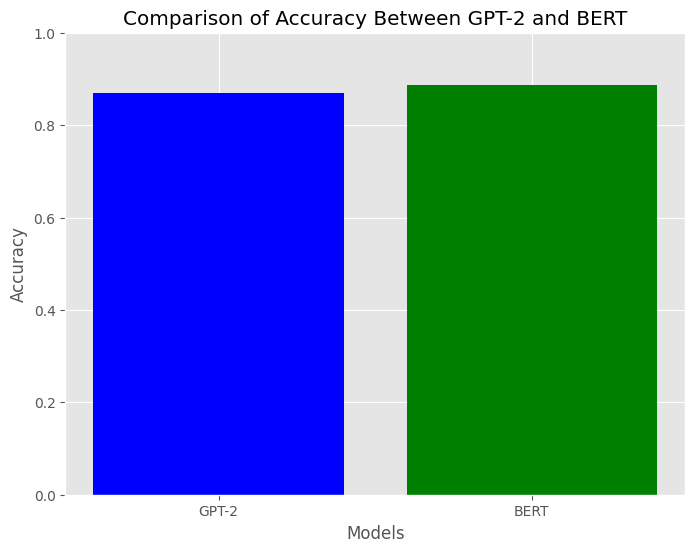

In [ ]:
models = ['Logistic Regression', 'GPT-2', 'BERT', 'XLNET']
accuracies = [accuracy_LR, accuracy_gpt2, accuracy_bert, accuracy_xlnet]

plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['red', 'blue', 'green', 'yellow'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Accuracy Between LR, GPT-2, BERT and XLNET')
plt.ylim(0, 1)  # Set the y-axis limit from 0 to 1
plt.show()